In [1]:
%run "Common setup.ipynb"

In [2]:
from SALib.analyze.radial_ee import analyze as ee_analyze
from SALib.analyze.sobol_jansen import analyze as jansen_analyze

from SALib.plotting.bar import plot as barplot

In [3]:
# results produced with
# python launch.py --specific_inputs oat_mc_10_samples.csv --num_cores 48
# python launch.py --specific_inputs extremes_samples.csv --num_cores 2
# python launch.py --specific_inputs moat_10_samples.csv --num_cores 46

In [4]:
template_df = pd.read_csv(f'{DATA_DIR}example_sample.csv', index_col=0)
target_num_vars = CIM_SPEC['num_vars']
oat_length = target_num_vars + 1

In [5]:
numeric_samples = pd.read_csv(f'{DATA_DIR}extreme_numeric_samples.csv', index_col=0)
numeric_vals = numeric_samples.loc[:, tgt_param].values

no_irrigation = pd.read_csv(f'{DATA_DIR}no_irrigation_extreme_results.csv', index_col=0)
np_res = no_irrigation.loc[:, 'SW Allocation Index']

# Targeted extremity testing with OAT

In [6]:
numeric_samples = pd.read_csv(f'{DATA_DIR}oat_mc_10_numeric_samples.csv', index_col=0)

# Locations of base value and perturbed value
target_runs = [0, numeric_samples.loc[:, perturbed_cols].columns.tolist().index(tgt_param)+1]

numeric_vals = numeric_samples.loc[target_runs, tgt_param].values

radial_no_irrigation_results = pd.read_csv(f'{DATA_DIR}oat_no_irrigation_10_results.csv', index_col=0)
radial_no_irrigation_results['Avg. $/ML'].fillna(radial_no_irrigation_results["Avg. Annual Profit ($M)"], inplace=True)

numeric_samples.loc[target_runs, tgt_param]
no_int = radial_no_irrigation_results.loc[target_runs, "SW Allocation Index"].values

In [7]:
radial_with_irrigation_results = pd.read_csv(f'{DATA_DIR}oat_with_irrigation_10_results.csv', index_col=0)
radial_with_irrigation_results['Avg. $/ML'].fillna(radial_with_irrigation_results["Avg. Annual Profit ($M)"], inplace=True)

with_int = radial_with_irrigation_results.loc[target_runs, "SW Allocation Index"].values

In [8]:
x_diff = np.abs(numeric_vals[0] - numeric_vals[1])

y_diff = np.abs(no_int[0] - no_int[1])
model_results = {tgt_metric: (y_diff / x_diff)}
no_ext_results = pd.DataFrame(model_results, index=[0])

y_diff = np.abs(with_int[0] - with_int[1])
model_results = {tgt_metric: (y_diff / x_diff)}
with_ext_results = pd.DataFrame(model_results, index=[0])

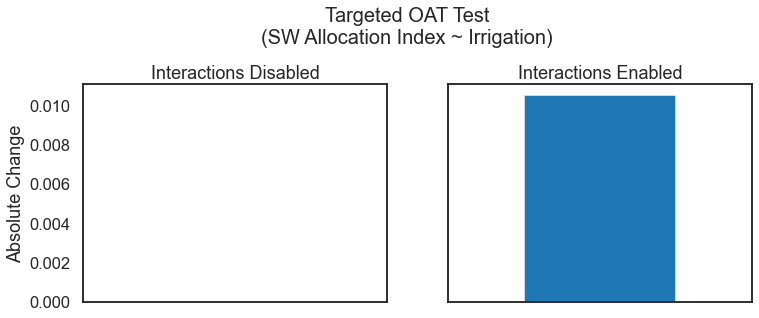

In [9]:
fig, axes = plt.subplots(1,2, figsize=(12,4), sharey=True, sharex=True)
no_ext_results.plot(kind='bar', 
                    legend=None, 
                    title='Interactions Disabled',
                    ax=axes[0], 
                    rot=0)

axes[0].set_ylabel('Absolute Change')

x_axis = axes[0].axes.get_xaxis()
x_axis.set_visible(False)

with_ext_results.plot(kind='bar', 
                      legend=None,
                      title='Interactions Enabled',
                      rot=0,
                      ax=axes[1])

x_axis = axes[1].axes.get_xaxis()
x_axis.set_visible(False)

fig.suptitle("Targeted OAT Test\n(SW Allocation Index ~ Irrigation)", x=0.5, y=1.15, fontsize=20);
fig.savefig(f'{FIG_DIR}targeted_oat_testing_sw_alloc~pipeandriser_irrigation_results.png', dpi=300, bbox_inches='tight')

In [10]:
### Extremity testing ###

## Extreme values without interactions ##
model_results = {}

x_diff = np.abs(numeric_vals[0] - numeric_vals[1])
y_diff = np.abs(np_res[0] - np_res[1])
model_results[tgt_metric] = (y_diff / x_diff)

no_ext_results = pd.DataFrame(model_results, index=[0])


## Extremes with interactions ##
with_irrigation = pd.read_csv(f'{DATA_DIR}with_irrigation_extreme_results.csv', index_col=0)
np_res = with_irrigation.loc[:, 'SW Allocation Index']
model_results = {}


y_diff = np.abs(np_res[0] - np_res[1])
model_results[tgt_metric] = (y_diff / x_diff)

with_ext_results = pd.DataFrame(model_results, index=[0])

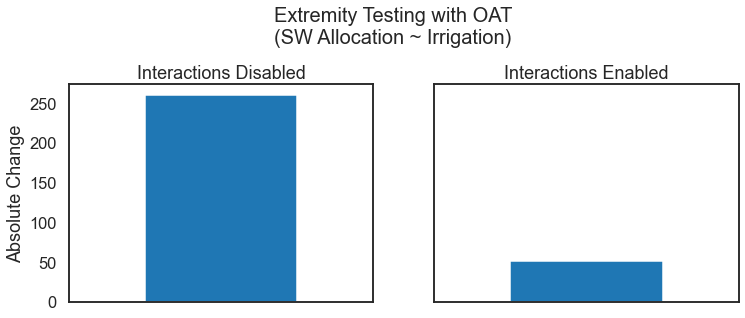

In [11]:
selected_cols = [c for c in with_ext_results.columns 
                 if tgt_param.lower() in c.lower()]

selected_no_ext = no_ext_results.loc[:, selected_cols]
selected_with_ext = with_ext_results.loc[:, selected_cols]

fig, axes = plt.subplots(1,2, figsize=(12,4), sharey=True, sharex=True)
no_ext_results.plot(kind='bar', 
                    legend=None, 
                    title='Interactions Disabled',
                    ax=axes[0], 
                    rot=0)

axes[0].set_ylabel('Absolute Change')

x_axis = axes[0].axes.get_xaxis()
x_axis.set_visible(False)

with_ext_results.plot(kind='bar', 
                      legend=None,
                      title='Interactions Enabled',
                      rot=0,
                      ax=axes[1])

x_axis = axes[1].axes.get_xaxis()
x_axis.set_visible(False)

fig.suptitle("Extremity Testing with OAT\n(SW Allocation ~ Irrigation)", x=0.5, y=1.15, fontsize=20);
fig.savefig(f'{FIG_DIR}extremity_testing_sw_alloc~pipeandriser_irrigation_results.png', dpi=300, bbox_inches='tight')

Conceptually, if model interactions are disabled, then there would be a very large difference.

From the perspective of the policy model, no water gets "used" by farmers as water extractions are not accounted for, resulting in large water allocations in subsequent years

Can confirm this by plotting the comparison for Dam Level...

In [12]:
np_res = no_irrigation.loc[:, 'Dam Level']
y_diff = np.abs(np_res[0] - np_res[1])
model_results[tgt_metric] = (y_diff / x_diff)
no_ext_results = pd.DataFrame(model_results, index=[0])

np_res = with_irrigation.loc[:, 'Dam Level']
y_diff = np.abs(np_res[0] - np_res[1])
model_results[tgt_metric] = (y_diff / x_diff)
with_ext_results = pd.DataFrame(model_results, index=[0])

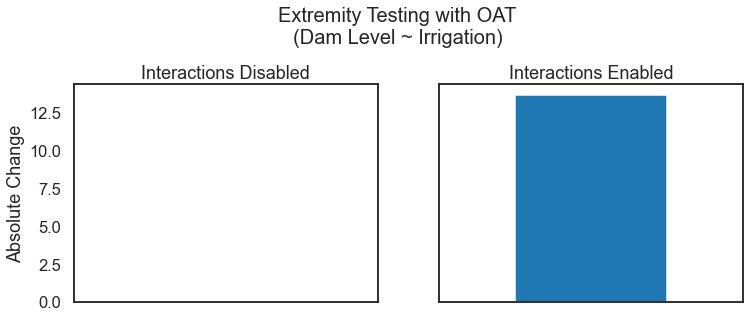

In [13]:
fig, axes = plt.subplots(1,2, figsize=(12,4), sharey=True, sharex=True)
no_ext_results.plot(kind='bar', 
                    legend=None, 
                    title='Interactions Disabled',
                    ax=axes[0], 
                    rot=0)

axes[0].set_ylabel('Absolute Change')

x_axis = axes[0].axes.get_xaxis()
x_axis.set_visible(False)

with_ext_results.plot(kind='bar', 
                      legend=None,
                      title='Interactions Enabled',
                      rot=0,
                      ax=axes[1])

x_axis = axes[1].axes.get_xaxis()
x_axis.set_visible(False)

fig.suptitle("Extremity Testing with OAT\n(Dam Level ~ Irrigation)", x=0.5, y=1.15, fontsize=20);
fig.savefig(f'{FIG_DIR}extremity_testing_dam_level~pipeandriser_irrigation_results.png', dpi=300, bbox_inches='tight')

In the above, we see that the Dam Level did not change at all, despite changes to irrigation efficiency